This notebook is an example for 'time series forecasting with ARIMA'. The reference for this notebook is given below. I tried to summarize this article and prepare an easy notebook for understanding basic consepts about 'ARIMA model'. For the source of this notebook, you can go to : https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/ . Some commands are different from the source for detailed explanation.


First we should explain 'time series'. 'Time series is a sequence where a metric is recorded over regular time intervals. Forecasting a time series can be broadly divided into two types:  

   1.If you use only the previous values of the time series to predict its future values, it is called _Univariate Time Series Forecasting_ .

   2.And if you use predictors other than the series (a.k.a exogenous variables) to forecast it is called _Multi Variate Time Series Forecasting_ .

In this notebook, we will focus a forecasting method called 'ARIMA model'. ARIMA, short for ‘AutoRegressive Integrated Moving Average’, is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values.

   check this videos for basic overview for acf,pacf,arima order :
    https://www.machinelearningplus.com/arima/implement-arima-model/
        https://www.machinelearningplus.com/arima/arima-forecast-test-results/

ARIMA, short for ‘AutoRegressive Integrated Moving Average’, is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values. For ARIMA model, our data should have at least two columns; _dates_ and _values_. ARIMA explains a given time series based on its past values,its own lags and lagged forecast errors

When you want to use ARIMA model for forecasting, the time series should have three important features :
* stationary
* non-Seasonal
* not a random white noise


An ARIMA model is characterized by 3 terms: p, d, q

where,

* __p__ is the order of the AR term ‘Auto Regressive’, number of lags of Y to be used as predictors

* __q__ is the order of the MA term  ‘Moving Average’, number of lagged forecast errors 

* __d__ is the number of differencing required to make the time series stationary

If a time series, has seasonal patterns, then you need to add seasonal terms and it becomes SARIMA, short for ‘Seasonal ARIMA’. 

Let me try to explain what does the '**p**','**q**','**d**'.

    VALUE OF d:

As I mentioned above, time series should be 'stationary' for ARIMA model. Because term ‘Auto Regressive’ in ARIMA means it is a linear regression model that uses its own lags as predictors. Linear regression models, as you know, work best when the predictors are not correlated and are independent of each other (If the last sentence doesn't make any sense, you should check 'Linear Regression' to refresh your memory) .

We explain 'why', now it is time for 'how to make stationary'.

According to the article, the most common approach is to difference it. It subtract the previous value from the current value. If the series are complex, more than one differencing may be needed. The value of  *d* is the minimum number of differencing needed to make the series stationary. If the time series is already stationary, then d=0. 

The first question in your mind can be 'how we know the minimum number of differencing needed' or 'how to differencing'. I try to explain these two questions in the rest of the notebook.




    VALUE OF p and q:
*'p'* is the order of the ‘Auto Regressive’ (AR) term. It refers to the "number of lags of Y to be used as predictors". It tells 'how many prior time steps to use in the regression'. AR models attempt to predict future values based on past values.

And *‘q’* is the order of the ‘Moving Average’ (MA) term. It refers to the "number of lagged forecast errors that" should go into the ARIMA Model. It tells 'how many prior errors will be considered'.MA models attempt to predict future values based on past forecasting errors.

Mathematical formula for AR and MA models are given below(images are from same article):

    A pure Auto Regressive (AR only) model is one where Yt depends only on its own lags. That is, Yt is a function of the ‘lags of Yt’. 
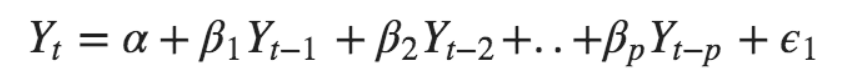

    Likewise a pure Moving Average (MA only) model is one where Yt depends only on the lagged forecast errors.
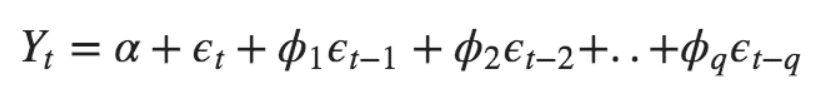

    An ARIMA model is one where the time series was differenced at least once to make it stationary and you combine the AR and the MA terms. So the equation becomes:

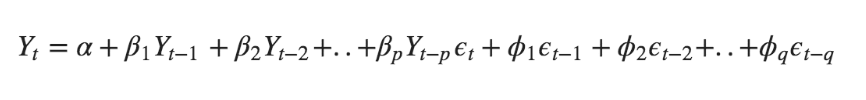

    Predicted Yt = Constant + Linear combination Lags of Y (upto p lags) + Linear Combination of Lagged forecast errors (upto q lags)

Now it is time to make some examples and explain details on real datasets.

We talked about the 'd' value but didn't mention about 'how to find'. The purpose for differencing is making time series stationary. According to complexity of series, more than one differencing may be needed. But you need to be careful to _'not over-difference'_ the series. An over deifferenced series may still be stationary, but it will affect the model in negative way

The right order of differencing is the minimum differencing required to get a near-stationary series which roams around a defined mean and the ACF plot reaches to zero fairly quick.

I think the critical explanation for d value is : 

    'If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing. On the other hand, if the lag 1 autocorrelation itself is too negative, then the series is probably over-differenced.In the event, you can’t really decide between two orders of differencing, then go with the order that gives the least standard deviation in the differenced series.'

Before finding the d value, we should check if the time series is stationary or not. For this purpose we use _'Augmented Dickey Fuller Test(ADF)'_ . Why we are doing this? Because, our time series can be stationary already and d value would be 0. The detail of Dickey Fuller Test is out of scope of this notebook. I just want to show 'how to use' and 'how to read results' of this test

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary. Basically, if the p value of Dickey Fuller Test is bigger than 0.05, the time series is non-stationary.

In [10]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Import data
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

In [11]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.value.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.464240
p-value: 0.124419


Since P-value is greater than the significance level, let’s difference the series and see how the autocorrelation plot looks like.

!!!The next two commands are doing same thing. The first one is directly taken from source code. When I run first command, my autocorrelation plot is limited,which is different than article.So i just add 'lags' parameter to 'plot_acf' command to have more detailed graph.Probably it is because of the version of statsmodels. !!!

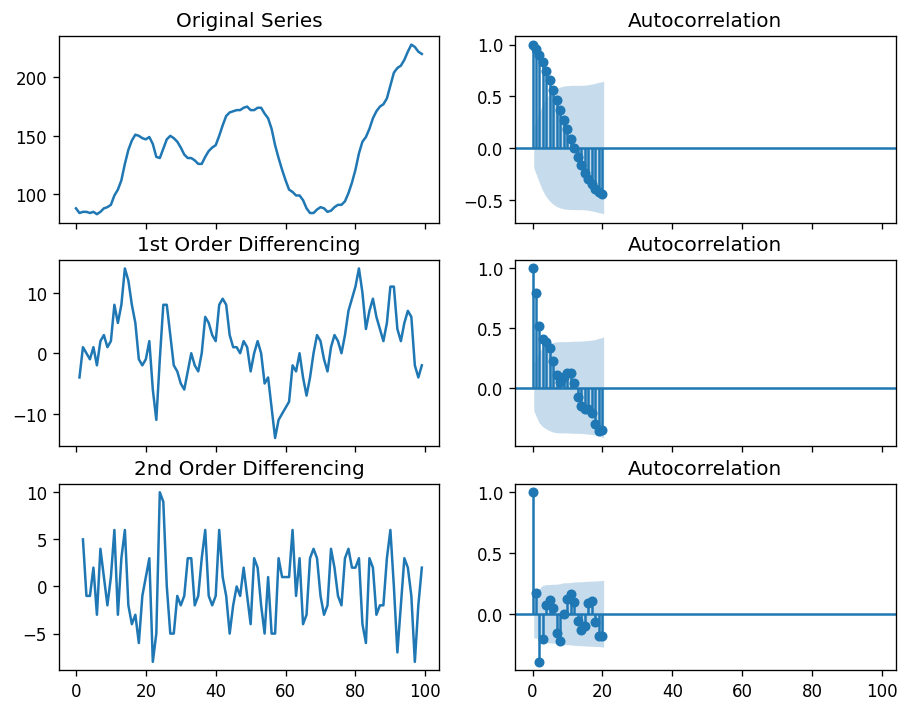

In [13]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Import data
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

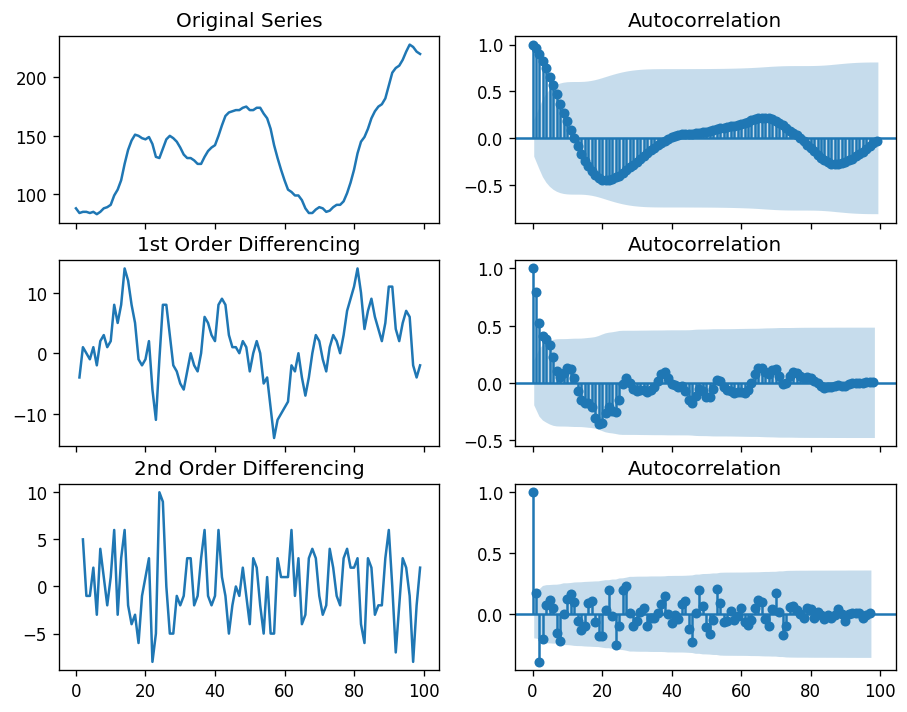

In [16]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Import data
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1],lags=99)

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1],lags=98)

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1],lags=97)

plt.show()

As you can see, you can apply differencing the series with  'df.value.diff()' command
When you check the autocorrelation graphs, the time series reaches stationarity with two orders of differencing. But on looking at the autocorrelation plot for the 2nd differencing the lag goes into the far negative zone fairly quick, which indicates, the series might have been over differenced. 

In [17]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)
result = adfuller(df.value.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.722238
p-value: 0.070268


In [18]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)
result = adfuller(df.value.diff().diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -9.929762
p-value: 0.000000


I applied ADF to the series with d=1 and d=2 . Accoring to plot_acf results 2nd differenced series might have been over differenced. When you check the p values, we can say that the series with one differencing (d=1)  is weak stationarity.

In the next command, you will see another stationary test from another library. Basically, it takes time series and test type as input and returns the value for d. When we apply to original series, it returns 2. you can see the details from : https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ndiffs.html 

In [28]:
from pmdarima.arima.utils import ndiffs
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)
y = df.value
y_1= df.value.diff().dropna()
y_2=df.value.diff().diff().dropna()
## Adf Test
a=ndiffs(y, test='adf')  # 2
print('according to adf , d value for time series should be :{0}'.format(a))

#apply adf test for two differencing series
b=ndiffs(y_2, test='adf')  # 2
print('according to adf , d value for 2 differencing series should be :{0}'.format(b))


according to adf , d value for time series should be :2
according to adf , d value for 2 differencing series should be :0


 
Now it is time to find 'p' value to check if the model needs any AR terms. We should look at the the Partial Autocorrelation (PACF) plot.

Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series. That way, you will know if that lag is needed in the AR term or not

we initially take the order of AR term to be equal to as many lags that crosses the significance limit in the PACF plot.

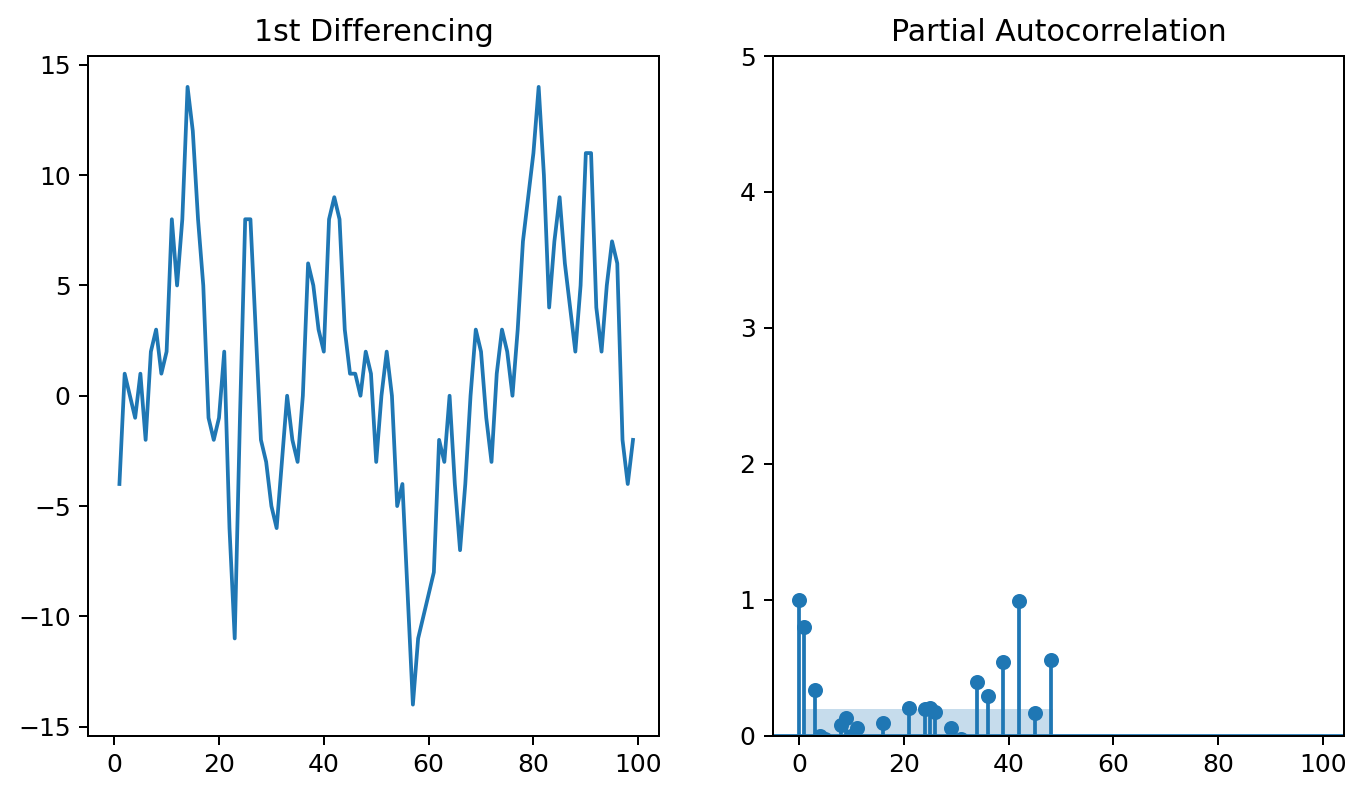

In [37]:
# PACF plot of 1st differenced series
import warnings
warnings.filterwarnings('ignore')
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':180})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.value.diff().dropna(), ax=axes[1],lags=48)

plt.show()

You can observe that the PACF lag 1 is quite significant since is well above the significance line. Lag 2 turns out to be significant as well, slightly managing to cross the significance limit (blue region).

Time for finding the 'q' value

Just like how we looked at the PACF plot for the number of AR terms, you can look at the ACF plot for the number of MA terms. An MA term is technically, the error of the lagged forecast.

!!!The source code on the article use 'austa.csv' dataset , but I used 'wwwusage.csv' for more data points!!!

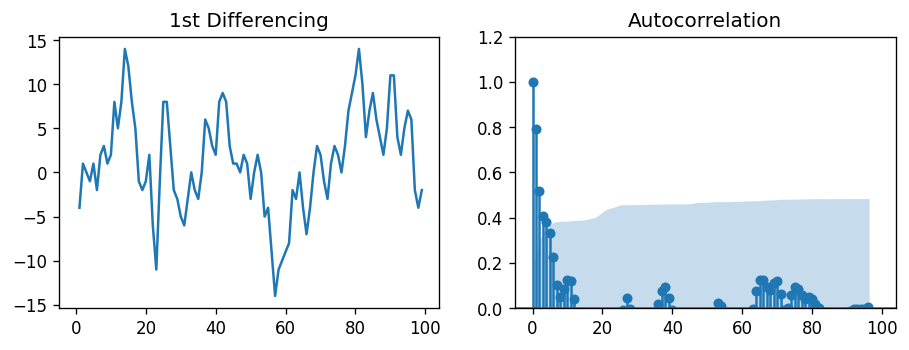

In [38]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

# Import data
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.value.diff().dropna(), ax=axes[1],lags=96)

plt.show()

Couple of lags are well above the significance line. So, let’s tentatively fix q as 2. When in doubt, go with the simpler model that sufficiently explains the Y.

9. How to build the ARIMA Model

We find the p,d,q values. Now we can fit our ARIMA model. For this purpose we will use statsmodels package

In [40]:
from statsmodels.tsa.arima_model import ARIMA
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)
# 1,1,2 ARIMA Model
model = ARIMA(df.value, order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   99
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -253.790
Method:                       css-mle   S.D. of innovations              3.119
Date:                Tue, 31 May 2022   AIC                            517.579
Time:                        06:15:29   BIC                            530.555
Sample:                             1   HQIC                           522.829
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.1202      1.290      0.868      0.385      -1.409       3.649
ar.L1.D.value     0.6351      0.257      2.469      0.014       0.131       1.139
ma.L1.D.value     0.5287      0.355     

When you check the summary,you can see the coefficients. For proper model, the p values of coefficients should be smaller than 0.05. If you check our summary , especially MA2 , p value is highly insignificant. 

Lets change our p,d,q values and fit model one more time.

In [41]:
model = ARIMA(df.value, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   99
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -253.790
Method:                       css-mle   S.D. of innovations              3.119
Date:                Tue, 31 May 2022   AIC                            515.579
Time:                        06:21:39   BIC                            525.960
Sample:                             1   HQIC                           519.779
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.1205      1.286      0.871      0.384      -1.400       3.641
ar.L1.D.value     0.6344      0.087      7.317      0.000       0.464       0.804
ma.L1.D.value     0.5297      0.089     

 The p values of AR1 and MA1 terms are highly significant. Model AIC has reduced. According to these two, We can call this model is better

Let’s plot the residuals to ensure there are no patterns (that is, look for constant mean and variance).

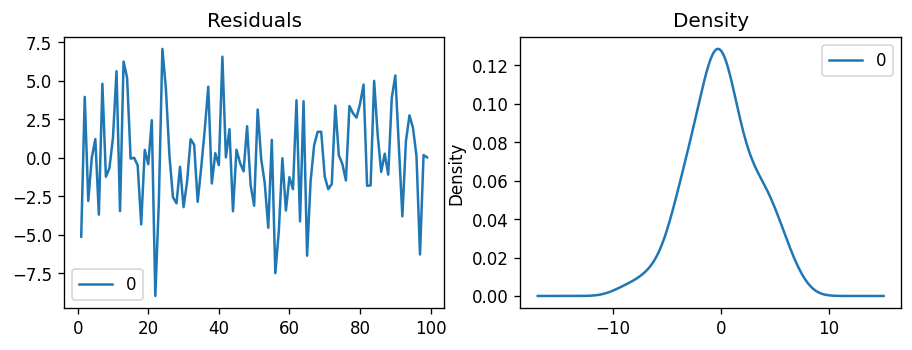

In [42]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

The residual errors seem fine with near zero mean and uniform variance.

In [ ]:
Let’s plot the actuals against the fitted values using

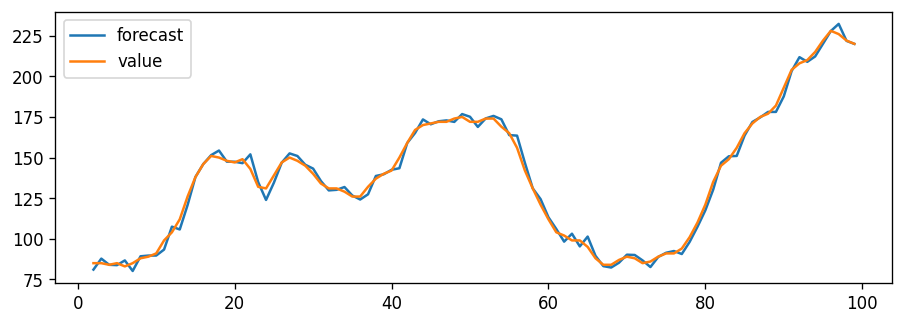

In [43]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

When you set (dynamic=False) the in-sample lagged values are used for prediction.

That is, the model gets trained up until the previous value to make the next prediction. This can make the fitted forecast and actuals look artificially good.

We haven’t actually forecasted into the future and compared the forecast with the actual performance. The real validation you need now is the Out-of-Time cross-validation

In [ ]:
How to do find the optimal ARIMA model manually using Out-of-Time Cross validation

In Out-of-Time cross-validation, you take few steps back in time and forecast into the future to as many steps you took back. Then you compare the forecast against the actuals.

To do out-of-time cross-validation, you need to create the training and testing dataset by splitting the time series into 2 contiguous parts in approximately 75:25 ratio or a reasonable proportion based on time frequency of series.

Most important note about cross-validation on time series : **You can't choose training data randomly. You should use past values for training, and use future values for test.**

In [44]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = df.value[:85]
test = df.value[85:]

For our dataset, we take first 85 points for training and last 15 points for test. And show the results on graph.

The gray part of grap means the prediction in that area has 95% confidence score. You can check the values by printing them.

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   84
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -216.887
Method:                       css-mle   S.D. of innovations              3.174
Date:                Tue, 31 May 2022   AIC                            441.775
Time:                        08:23:28   BIC                            451.498
Sample:                             1   HQIC                           445.683
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.8435      1.446      0.583      0.560      -1.991       3.678
ar.L1.D.value     0.6528      0.095      6.899      0.000       0.467       0.838
ma.L1.D.value     0.4877      0.106     

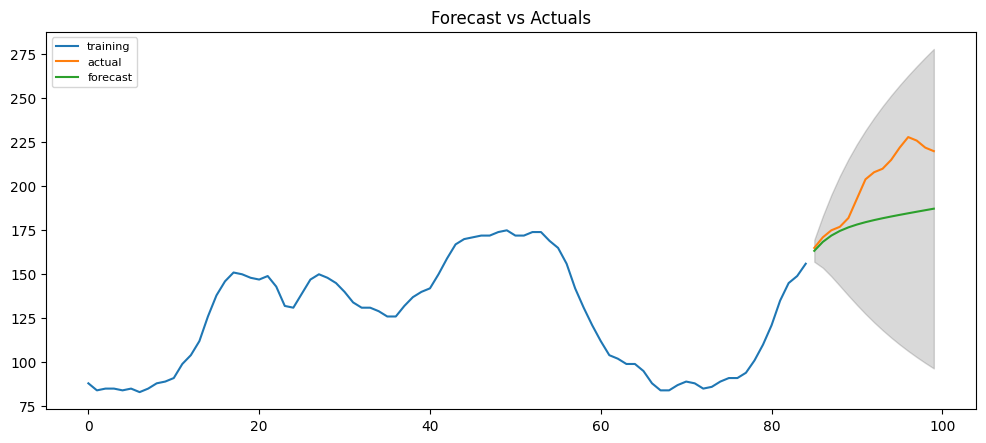

In [48]:
# Build Model
#  
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [47]:
conf

array([[157.10534189, 169.54531718],
       [153.70514668, 183.09483485],
       [148.81224713, 195.1987065 ],
       [143.38650311, 205.91734729],
       [137.89400563, 215.45067403],
       [132.55945375, 224.00873949],
       [127.48340039, 231.77478495],
       [122.70157871, 238.89833037],
       [118.21633399, 245.49795872],
       [114.01362483, 251.66665005],
       [110.07224866, 257.47713594],
       [106.36878215, 262.98647648],
       [102.88013635, 268.23971775],
       [ 99.5847848 , 273.27271927],
       [ 96.46326176, 278.11430296]])

As you can see at 'conf', our model predict a lower and upper boundry for prediction with 95% . You can see that the difference between lower and upper values aregetting bigger and bigger.

Now lets try with other p,d,q values and compare the results.

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   83
Model:                 ARIMA(5, 2, 5)   Log Likelihood                -213.823
Method:                       css-mle   S.D. of innovations              3.105
Date:                Tue, 31 May 2022   AIC                            451.645
Time:                        08:25:03   BIC                            480.671
Sample:                             2   HQIC                           463.306
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0402      0.080      0.502      0.616      -0.117       0.197
ar.L1.D2.value    -0.2607      0.814     -0.320      0.749      -1.857       1.335
ar.L2.D2.value    -0.2752      0.535

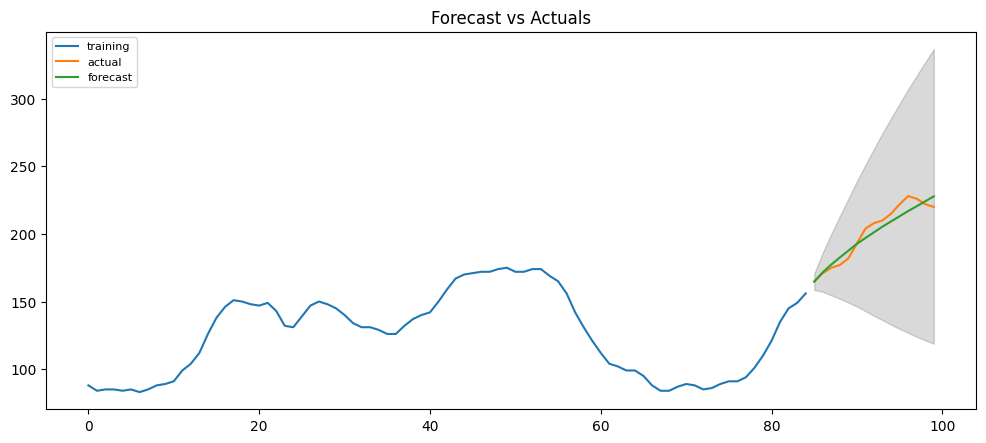

In [50]:
# Build Model
model = ARIMA(train, order=(5, 2, 5))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   83
Model:                 ARIMA(3, 2, 1)   Log Likelihood                -214.248
Method:                       css-mle   S.D. of innovations              3.153
Date:                Tue, 31 May 2022   AIC                            440.497
Time:                        09:16:17   BIC                            455.010
Sample:                             2   HQIC                           446.327
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0483      0.084      0.577      0.564      -0.116       0.212
ar.L1.D2.value     1.1386      0.109     10.399      0.000       0.924       1.353
ar.L2.D2.value    -0.5923      0.155

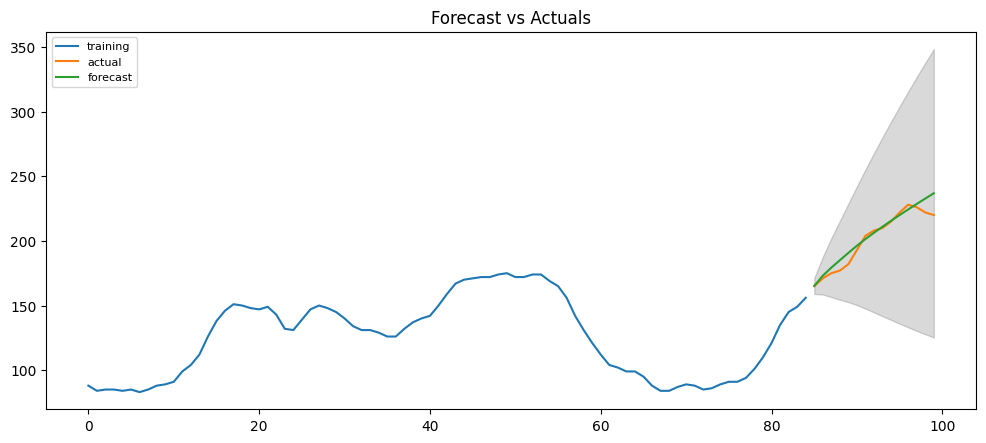

In [61]:
# Build Model
model = ARIMA(train, order=(3, 2, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Remember that: while comparing our models we should check the p values of coefficients and AIC values(small AIC is better).

According to that, the second model is better. You can see that also from the graph.

Accuracy Metrics for Time Series Forecast

The commonly used accuracy metrics to judge forecasts are:

    * Mean Absolute Percentage Error (MAPE)
    * Mean Error (ME)
    * Mean Absolute Error (MAE)
    * Mean Percentage Error (MPE)
    * Root Mean Squared Error (RMSE)
    * Lag 1 Autocorrelation of Error (ACF1)
    * Correlation between the Actual and the Forecast (corr)
    * Min-Max Error (minmax)

Typically, if you are comparing forecasts of two different series, the MAPE, Correlation and Min-Max Error can be used. We use these metrics because they return a percentage errors that vary between 0 and 1.

In [53]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

{'mape': 0.02250131273800086,
 'me': 3.2307825623681237,
 'mae': 4.548322092626688,
 'mpe': 0.01642099897032476,
 'rmse': 6.373238676488524,
 'acf1': 0.5105506347565559,
 'corr': 0.9674576468465738,
 'minmax': 0.021631546969263393}

As you can see from the results, our last model's MAPE is around 2.2% which means our model is about 97.8% accurate in predicting the next 15 observations

In [ ]:
12. How to do Auto Arima Forecast in Python

We learned how to find p,d,q values, but implying different values to model for best ones and check the model's AIC value is time_wasting operation. Luckily python has a nice function which name is auto_arima().

As you can see below, you give some parameters and auto_arima() finds the best values. For details you can check : https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

In [63]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

model = pm.auto_arima(df.value, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=525.587, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=533.474, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=532.437, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=525.893, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=531.477, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=515.248, Time=0.05 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=513.459, Time=0.04 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=515.284, Time=0.05 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=511.465, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=530.444, Time=0.01 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=513.291, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=513.256, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=523.592, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time

As you can see, there are 'inf' results in AIC values. Some explanation for this you can check these websites :
* https://stats.stackexchange.com/questions/160612/auto-arima-doesnt-calculate-aic-values-for-the-majority-of-models
        
* https://robjhyndman.com/hyndsight/badarima/
        
        
   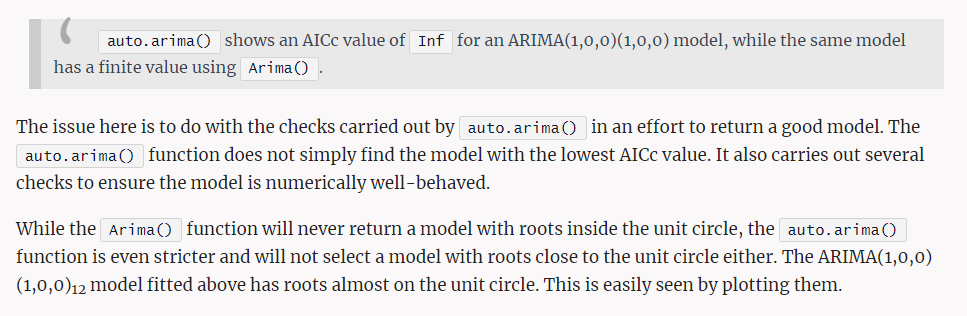
        
       
* https://otexts.com/fpp2/arima-r.html
        

## The result od AUTO_ARIMA is different from the article, because of that the following two title should be out of notebook!!! 

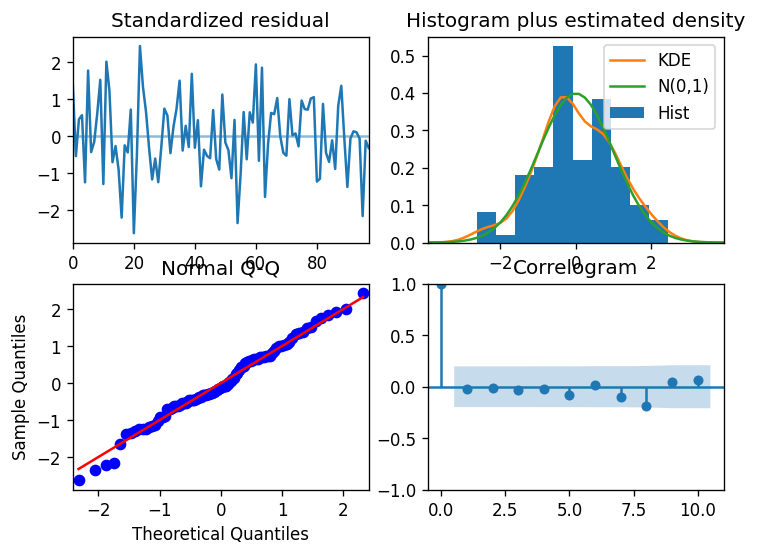

In [64]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

Bottom left: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

Top Right: The density plot suggest normal distribution with mean zero.(BUT for our case it is not suitable... not true for us)

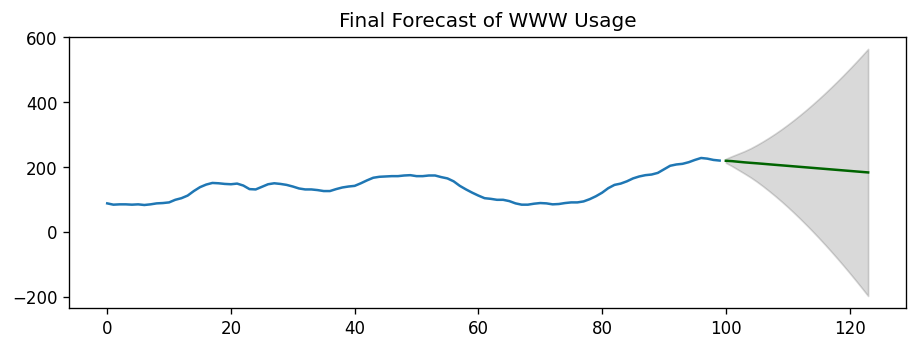

In [65]:
# Forecast
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.value), len(df.value)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df.value)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of WWW Usage")
plt.show()

In [ ]:
14. How to automatically build SARIMA model in python

The problem with plain ARIMA model is it does not support seasonality.If your time series has defined seasonality, then, go for SARIMA which uses seasonal differencing. Seasonal differencing is similar to regular differencing, but, instead of subtracting consecutive terms, you subtract the value from previous season.

the model will be represented as SARIMA(p,d,q)x(P,D,Q), where, P, D and Q are SAR, order of seasonal differencing and SMA terms respectively and 'x' is the frequency of the time series.

Here’s some practical advice on building SARIMA model:

As a general rule, set the model parameters such that D never exceeds one. And the total differencing ‘d + D’ never exceeds 2. Try to keep only either SAR or SMA terms if your model has seasonal components.

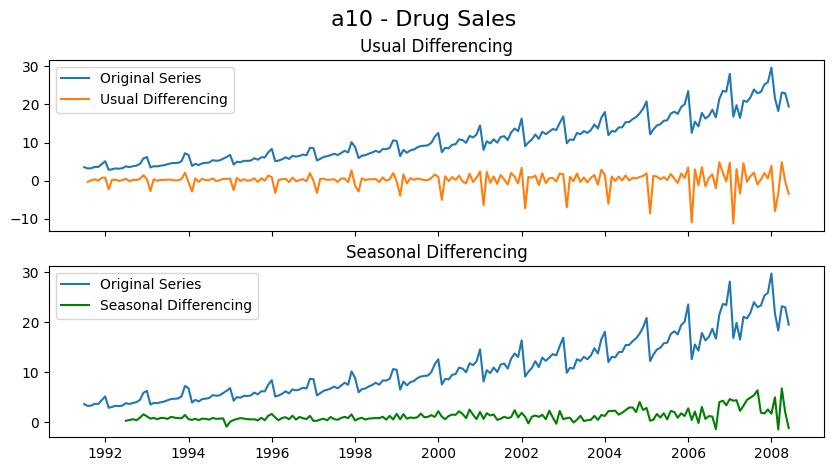

In [66]:
# Import
data = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(data[:], label='Original Series')
axes[0].plot(data[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(data[:], label='Original Series')
axes[1].plot(data[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('a10 - Drug Sales', fontsize=16)
plt.show()

As you can clearly see, the seasonal spikes is intact after applying usual differencing (lag 1). Whereas, it is rectified after seasonal differencing.

In [67]:
# !pip3 install pyramid-arima
import pmdarima as pm

# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=534.818, Time=0.66 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=624.061, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=596.068, Time=0.27 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=611.475, Time=0.20 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=757.274, Time=0.01 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=559.407, Time=0.15 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.20 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=536.817, Time=2.66 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=543.106, Time=0.74 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=537.786, Time=3.52 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=594.467, Time=0.19 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=529.829, Time=0.75 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=555.198, Time=0.16 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.43 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AI

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  204
Model:             SARIMAX(1, 0, 2)x(1, 1, 2, 12)   Log Likelihood                -254.042
Date:                            Tue, 31 May 2022   AIC                            524.085
Time:                                    09:26:25   BIC                            550.145
Sample:                                         0   HQIC                           534.639
                                            - 204                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0047      0.009      0.553      0.580      -0.012       0.021
ar.L1          0.9772      0.017     55.864      0.000       0.943       1.012
ma.L1         -0.9153      0.055    -16.581      0.000      -1.023      -0.807
ma.L2          0.2106      0.058      3.646      0.000       0.097       0.324
ar.S.L12       0.8518      0.174      4.887      0.000       0.510       1.193
ma.S.L12      -1.5678      0.195     -8.053      0.000      -1.949      -1.186
ma.S.L24       0.7352      0.116      6.360      0.000       0.509       0.962
sigma2         0.7507      0.062     12.077      0.000       0.629       0.872
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):               142.24
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):              14.51   Skew:                             0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The article's value is different but our model has lower AIC and significant P values. I will use (1,0,2)(1,1,2)[12] values for prediction. for the next 24 months, lets make a prediction.

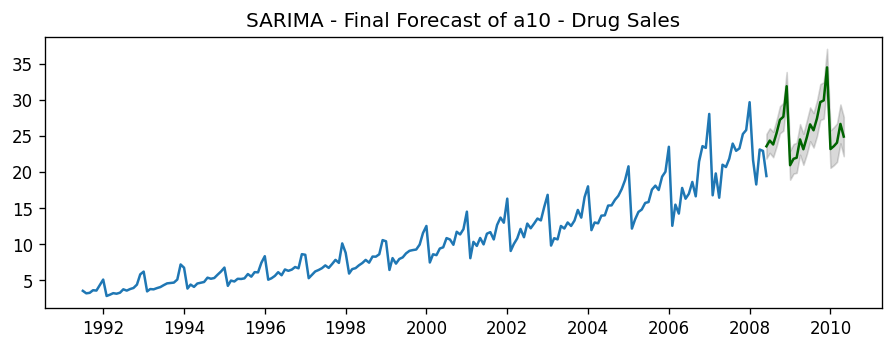

In [68]:
# Forecast
n_periods = 24
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of a10 - Drug Sales")
plt.show()

In [70]:
data.head(-1)

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869
...,...
2008-01-01,29.665356
2008-02-01,21.654285
2008-03-01,18.264945


In [ ]:
15. How to build SARIMAX Model with exogenous variable

In [71]:
# Import Data
data = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

In [72]:
# Compute Seasonal Index
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# multiplicative seasonal component
result_mul = seasonal_decompose(data['value'][-36:],   # 3 years
                                model='multiplicative', 
                                extrapolate_trend='freq')

seasonal_index = result_mul.seasonal[-12:].to_frame()
seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month

# merge with the base data
data['month'] = data.index.month
df = pd.merge(data, seasonal_index, how='left', on='month')
df.columns = ['value', 'month', 'seasonal_index']
df.index = data.index  # reassign the index.

In [79]:
print(result_mul.seasonal)

date
2005-07-01    0.970490
2005-08-01    1.050900
2005-09-01    0.998881
2005-10-01    1.059657
2005-11-01    1.146141
2005-12-01    1.150750
2006-01-01    1.316913
2006-02-01    0.803279
2006-03-01    0.850667
2006-04-01    0.832227
2006-05-01    0.954751
2006-06-01    0.865344
2006-07-01    0.970490
2006-08-01    1.050900
2006-09-01    0.998881
2006-10-01    1.059657
2006-11-01    1.146141
2006-12-01    1.150750
2007-01-01    1.316913
2007-02-01    0.803279
2007-03-01    0.850667
2007-04-01    0.832227
2007-05-01    0.954751
2007-06-01    0.865344
2007-07-01    0.970490
2007-08-01    1.050900
2007-09-01    0.998881
2007-10-01    1.059657
2007-11-01    1.146141
2007-12-01    1.150750
2008-01-01    1.316913
2008-02-01    0.803279
2008-03-01    0.850667
2008-04-01    0.832227
2008-05-01    0.954751
2008-06-01    0.865344
Name: seasonal, dtype: float64


In [80]:
seasonal_index

,seasonal,month
date,,
2007-07-01,0.970490,7
2007-08-01,1.050900,8
2007-09-01,0.998881,9
2007-10-01,1.059657,10
2007-11-01,1.146141,11
2007-12-01,1.150750,12
2008-01-01,1.316913,1
2008-02-01,0.803279,2
2008-03-01,0.850667,3


In [81]:
df.head(10)

,value,month,seasonal_index
date,,,
1991-07-01,3.526591,7,0.970490
1991-08-01,3.180891,8,1.050900
1991-09-01,3.252221,9,0.998881
1991-10-01,3.611003,10,1.059657
1991-11-01,3.565869,11,1.146141
1991-12-01,4.306371,12,1.150750
1992-01-01,5.088335,1,1.316913
1992-02-01,2.814520,2,0.803279
1992-03-01,2.985811,3,0.850667


In [82]:
import pmdarima as pm

# SARIMAX Model
sxmodel = pm.auto_arima(df[['value']], exogenous=df[['seasonal_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=536.818, Time=0.80 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=626.061, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=598.068, Time=0.33 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=613.475, Time=0.24 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=759.274, Time=0.07 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=561.407, Time=0.19 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.41 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=538.817, Time=3.04 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=545.106, Time=0.87 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=539.590, Time=3.58 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=596.467, Time=0.24 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=531.829, Time=0.84 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=557.198, Time=0.20 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.63 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AI

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  204
Model:             SARIMAX(1, 0, 2)x(1, 1, 2, 12)   Log Likelihood                -253.951
Date:                            Tue, 31 May 2022   AIC                            525.902
Time:                                    09:39:42   BIC                            555.220
Sample:                                07-01-1991   HQIC                           537.776
                                     - 06-01-2008                                         
Covariance Type:                              opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          0.0053      0.009      0.586      0.558      -0.012       0.023
seasonal_index  1.175e-06   1.07e+04    1.1e-10      1.000    -2.1e+04     2.1e+04
ar.L1              0.9767      0.018     52.863      0.000       0.941       1.013
ma.L1             -0.9125      0.057    -15.904      0.000      -1.025      -0.800
ma.L2              0.2181      0.059      3.666      0.000       0.102       0.335
ar.S.L12           0.8410      0.156      5.395      0.000       0.535       1.146
ma.S.L12          -1.5837      0.178     -8.911      0.000      -1.932      -1.235
ma.S.L24           0.7667      0.112      6.848      0.000       0.547       0.986
sigma2             0.7494      0.066     11.296      0.000       0.619       0.879
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):               142.76
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):              14.42   Skew:                             0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

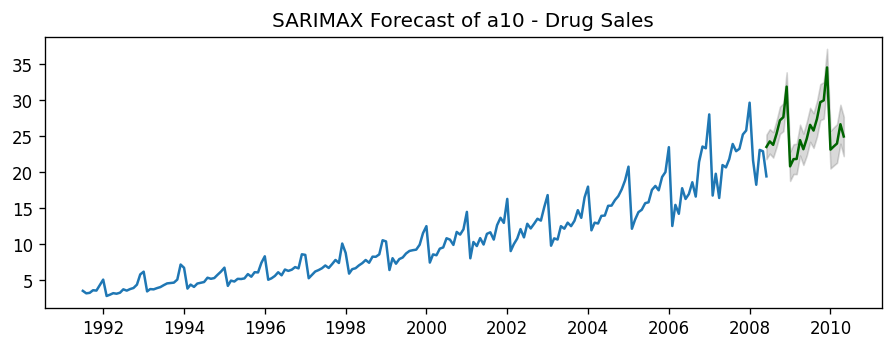

In [87]:
# Forecast
n_periods = 24
fitted, confint = sxmodel.predict(n_periods=n_periods, 
                                  exogenous=np.tile(seasonal_index.seasonal, 2).reshape(-1,1), 
                                  return_conf_int=True)

index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data['value'])
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMAX Forecast of a10 - Drug Sales")
plt.show()

After finished half of notebook, you can watch to understand :

   https://www.machinelearningplus.com/arima/understanding-arima-model/
    
   https://www.machinelearningplus.com/arima/building-auto-regressive-model/
   
   https://www.machinelearningplus.com/arima/implement-arima-model/
    
   https://www.machinelearningplus.com/arima/arima-forecast-test-results/